In [38]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [39]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [40]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [41]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [42]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [43]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['cats', 'dogs']


In [44]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [45]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [46]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [47]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [48]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 78ms/step - accuracy: 0.5646 - loss: 2.3905 - val_accuracy: 0.7056 - val_loss: 0.5706
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 75ms/step - accuracy: 0.7115 - loss: 0.5749 - val_accuracy: 0.7694 - val_loss: 0.4843
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.7480 - loss: 0.5269 - val_accuracy: 0.6452 - val_loss: 0.7372
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.7821 - loss: 0.4634 - val_accuracy: 0.7200 - val_loss: 0.5181
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - accuracy: 0.8323 - loss: 0.3804 - val_accuracy: 0.7678 - val_loss: 0.5185
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - accuracy: 0.8534 - loss: 0.3445 - val_accuracy: 0.6336 - val_loss: 1.4501
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.8937 - loss: 0.2521 - val_accuracy: 0.7694 - val_loss: 0.5447
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.9290 - loss: 0.1755 - 

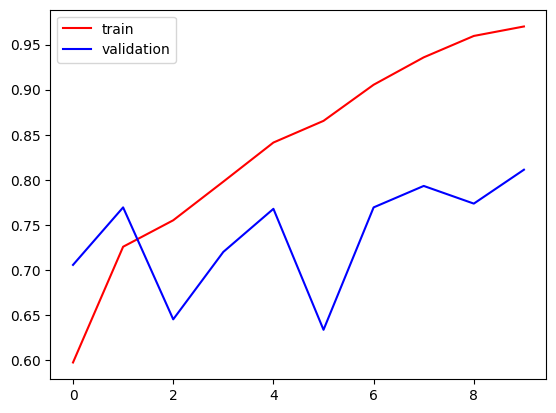

In [49]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

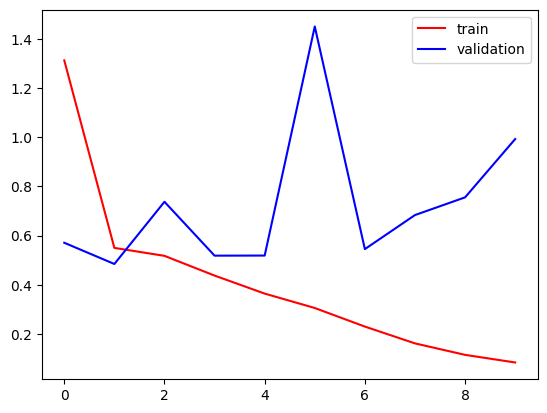

In [50]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [51]:
# ways to reduce overfitting

# Add more data
# Data Augmentation -> next video
# L1/L2 Regularizer
# Dropout
# Batch Norm
# Reduce complexity

In [52]:
import cv2

In [67]:
test_img = cv2.imread('/content/cat.jpeg')

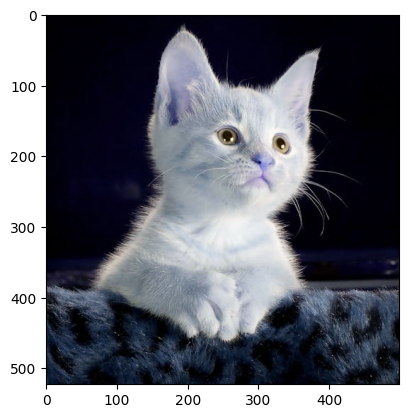

In [68]:
plt.imshow(test_img)

In [69]:
test_img.shape

(523, 500, 3)

In [70]:
test_img = cv2.resize(test_img,(256,256))

In [71]:
test_input = test_img.reshape((1,256,256,3))

In [72]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([[1.]], dtype=float32)